## Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, changing the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.69%, although it varies randomly.

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
from tensorflow import function, GradientTape, reshape
from numpy import float32, int32, argmax, ndarray
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from time import time
from typing import Tuple, Any


def get_cifar10() -> Tuple[Tuple[ndarray, ndarray], Tuple[ndarray, ndarray]]:
    """
    Loads and processes the CIFAR-10 dataset.

    Returns:
        Tuple[Tuple[ndarray, ndarray], Tuple[ndarray, ndarray]]: The processed dataset spit into training and testing sets.

    Side Effects: 
        None
    """
    # Load and split the CIFAR-10 dataset.
    (xTrain, yTrain), (xTest, yTest) = cifar10.load_data()

    # Do some pre-processing on the images.
    # Convert pixel values from integer to float32.
    xTrain = xTrain.astype(float32)
    xTest = xTest.astype(float32)

    # Normalize the pixels to be within 0 and 1.
    xTrain /= 255.
    xTest /= 255.

    # Set the correct classifications as integers.
    yTrain = yTrain.astype(int32)
    yTest = yTest.astype(int32)

    return (xTrain, yTrain), (xTest, yTest)


class CIFAR10Classifier(Model):
    """
    A classifier for the CIFAR-10 dataset using a convolutional neural network (CNN).
    Extends the basic Keras model.
    """

    def __init__(self):
        """
        Constructs an object of the CIFAR10Classifier class.
        """
        # Call the superclass constructor.
        Model.__init__(self)

        # Initialize the layers.
        self.conv_1 = Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = Dropout(0.25)
        self.dense_5 = Dense(128, activation='relu')
        self.drop_6 = Dropout(0.5)
        self.dense_7 = Dense(10, activation='softmax')

    def call(self, inputs):
        # Run the inputs through the layers.
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = Flatten()(x)    # Flatten is necessary for dense layers.
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x


def train_network_optimizable(xTrain, yTrain, batchSize: int, numEpochs: int, learnRate: float) -> None:
    """
    Trains a tensorflow model by manually iterating over the training data.

    Args:
        xTrain: Collection of features to train the model.
        yTrain: Collections of targets to train the model.
        batchSize (int): Size of each data batch.
        numEpochs (int): Number of times the entire dataset will be iterated over.
        learnRate (float): Rate at which the model learns from each batch.
        
    Returns:
        None

    Side Effects: 
        None
    """

    def forward_pass(_model, _xData, _yTrue, _lossFunc):
        """
        Performs a forward pass through the model to calculate loss.

        Args:
            _model: The trained model.
            _xData: Collection of features to pass through the model.
            _yTrue: Collections of targets to compare the model's predictions against.
            _lossFunc: The function to be used to calculate loss.

        Returns:
            float: The loss calculated from the forward pass.
            
        Side Effects:
            None
        """
        # Get the model's predictions from the set of features.
        yPredicted = _model(_xData)
        
        # Calculate the loss between the true and predicted values.
        loss = _lossFunc(_yTrue, yPredicted)

        return loss


    @function()
    def train_iteration(_xTrain, _yTrain, _model, _optimizer, _lossFunc):
        """
        Performs one training iteration on the model.

        Args:
            _xTrain: Collection of features to train the model.
            _yTrain: Collections of targets to train the model.
            _model: The model to be trained.
            _optimizer: The optimization function to be used to train the model.
            _lossFunc: The function to be used to calculate loss.

        Returns:
            float: The loss calculated from the forward pass.
            
        Side Effects:
            The model's trainable weights will be altered.
        """
        with GradientTape() as tape:
            # Calculate the loss of the training data.
            loss = forward_pass(_model, _xTrain, _yTrain, _lossFunc)

            # Apply the update to the network (one at a time).
            grads = tape.gradient(loss, _model.trainable_variables)
            _optimizer.apply_gradients(zip(grads, _model.trainable_variables))
            
        return loss


    def train_loop(_xTrain, _yTrain, _batchSize: int, _numEpochs: int, _model, _optimizer, _lossFunc):
        """
        Trains the model.

        Args:
            _xTrain: Collection of features to train the model.
            _yTrain: Collections of targets to train the model.
            _batchSize (int): Size of each data batch.
            _numEpochs (int): Number of times the entire dataset will be iterated over.
            _model: The model to be trained.
            _optimizer: The optimization function to be used to train the model.
            _lossFunc: The function to be used to calculate loss.
            
        Returns:
            None
            
        Side Effects: 
            The model's trainable weights will be altered.
        """
        # Convert the training data arrays to a dataset.
        dataset = Dataset.from_tensor_slices((_xTrain, _yTrain))

        # For each epoch...
        for epochNum in range(_numEpochs):
            print("beginning epoch %d" % epochNum)
            start = time()

            # Shuffle the dataset.
            dataset.shuffle(_xTrain.shape[0])
            
            # Split the dataset into batches.
            batches = dataset.batch(batch_size=_batchSize, drop_remainder=True)

            # For each batch...
            for batchNum, (xBatch, yBatch) in enumerate(batches):
                # Reshape the x data.
                xBatch = reshape(xBatch, [-1, 32, 32, 3])
                
                # Train the model.
                loss = train_iteration(xBatch, yBatch, _model, _optimizer, _lossFunc)

            end = time()
            print("took %1.1f seconds for epoch #%d" % (end-start, epochNum))

    # Create a default object of our CIFAR-10 classifier.
    cifarModel = CIFAR10Classifier()

    # Configure the training properties.
    ## Set the optimizer.
    optimizer = Adam(learnRate)
    
    ## Set the loss function.
    """
    If labels are integers, use sparse categorical crossentropy
    If labels are one-hot encoded, use standard crossentropy
    
    The network's final layer is softmax, so from_logits = False.
    """
    lossFunc = SparseCategoricalCrossentropy(from_logits=False)

    # Start the training.
    train_loop(xTrain, yTrain, batchSize, numEpochs, cifarModel, optimizer, lossFunc)


def train_network_simple(xTrain, yTrain, batchSize: int, numEpochs: int, learnRate: float, validTrainRatio: float) -> Tuple[History, CIFAR10Classifier]:
    """
    Trains a tensorflow model using the built-in fit function.

    Args:
        xTrain: Collection of features to train the model.
        yTrain: Collections of targets to train the model.
        batchSize (int): Size of each data batch.
        numEpochs (int): Number of times the entire dataset will be iterated over.
        learnRate (float): Rate at which the model learns from each batch.
        validTrainRatio (float): Ratio of validation data to training data.

    Returns:
        Tuple[History, CIFAR10Classifier]: A tuple of the training history and the trained model.

    Side Effects: 
        None
    """
    # Create a default object of our CIFAR-10 classifier.
    cifarModel = CIFAR10Classifier()

    # Configure the classifier's properties (loss and optimizer).
    cifarModel.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    # Train the model using the input training data.
    history = cifarModel.fit(xTrain, yTrain, batch_size=batchSize, epochs=numEpochs, validation_split=validTrainRatio)

    return history, cifarModel

Epoch 1/5
524/524 [==============================] - 139s 263ms/step - loss: 1.6774 - accuracy: 0.3906 - val_loss: 1.3298 - val_accuracy: 0.5222
Epoch 2/5
524/524 [==============================] - 140s 267ms/step - loss: 1.3239 - accuracy: 0.5262 - val_loss: 1.1254 - val_accuracy: 0.6096
Epoch 3/5
524/524 [==============================] - 140s 267ms/step - loss: 1.1714 - accuracy: 0.5874 - val_loss: 1.0505 - val_accuracy: 0.6332
Epoch 4/5
524/524 [==============================] - 142s 271ms/step - loss: 1.0785 - accuracy: 0.6199 - val_loss: 1.0269 - val_accuracy: 0.6352
Epoch 5/5
524/524 [==============================] - 161s 308ms/step - loss: 1.0090 - accuracy: 0.6425 - val_loss: 0.9765 - val_accuracy: 0.6627
313/313 - 11s - loss: 0.9687 - accuracy: 0.6607 - 11s/epoch - 35ms/step

Test Accuracy: 66.07%

313/313 [==============================] - 11s 34ms/step
Confusion matrix (rows: true classes; columns: predicted classes):
[[624  23  72  37  27   8  16  14 114  65]
 [ 14 814   

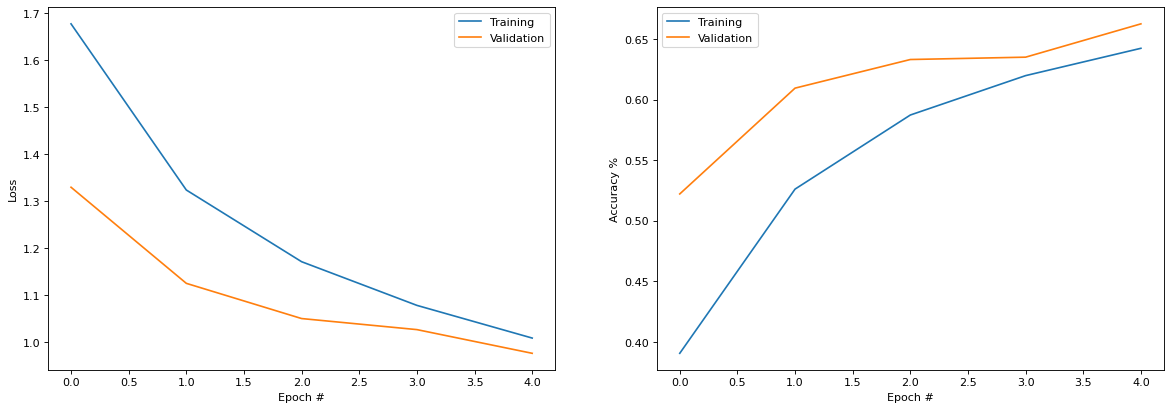

In [4]:
batchSize = 64          # Size of each data batch.
numEpochs = 5           # Number of times the entire dataset will be iterated over.
learnRate = 0.1         # Rate at which the model learns from each batch.
validTrainRatio = 0.33  # Ratio of validation data to training data.

# Get the CIFAR-10 dataset.
(xTrain, yTrain), (xTest, yTest) = get_cifar10()

# Train the model.
history, cifarModel = train_network_simple(xTrain, yTrain, batchSize, numEpochs, learnRate, validTrainRatio)

# Output the results.
fig, ax = pyplot.subplots(1, 2, figsize=(18, 6), dpi=80) # Create a 2 by 1 plot grid.

## Plot the losses.
ax[0].plot(history.epoch, history.history['loss'], label='Training')
ax[0].plot(history.epoch, history.history['val_loss'], label='Validation')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch #')
ax[0].legend()

## Plot the Accuracies.
ax[1].plot(history.epoch, history.history['accuracy'], label='Training')
ax[1].plot(history.epoch, history.history['val_accuracy'], label='Validation')
ax[1].set_ylabel('Accuracy %')
ax[1].set_xlabel('Epoch #')
ax[1].legend()

## Print the test accuracy.
scores = cifarModel.evaluate(xTest, yTest, verbose=2)
print("\nTest Accuracy: %.2f%%\n" % (scores[1] * 100))

## Print the confusion matrix.
predictions = cifarModel.predict(xTest)
cm = confusion_matrix(yTest, argmax(predictions, axis=1), labels=list(range(10)))
print(
    'Confusion matrix (rows: true classes; columns: predicted classes):\n'
    f"{cm}\n"
)

## Print the accuracy of each of the 10 classes.
print('Classification accuracy for each class:')
for i, j in enumerate(cm.diagonal() / cm.sum(axis=1)):
    print("%d: %.4f" % (i, j))